In [92]:
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [90]:
# Pilfered from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Franklin Gothic Book',
    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'lightgrey',
         'axes.facecolor': 'None',
         'axes.grid': False,
         'axes.labelcolor': 'dimgrey',
         'axes.spines.right': False,
         'axes.spines.top': False,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'w',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': True,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


In [ ]:
#pymongo stuff
client = MongoClient('localhost', 27017)
# Access/Initiate Database
db = client['samdatascidb']
# Access/Initiate Collection
wsbs = db['wsb_submissions']

In [4]:
wsbs.find_one()

{'_id': ObjectId('605bb15d5df7eedfb49c1b8b'),
 'id': 'mcheu3',
 'fullname': 't3_mcheu3',
 'selftext': '',
 'created_utc': '2021-03-24 17:38:13',
 'num_comments': 0,
 'score': 1,
 'upvote_ratio': 1.0,
 'is_original_content': False,
 'permalink': '/r/wallstreetbets/comments/mcheu3/ill_just_blame_it_on_my_wifes_bf_those_16_shares/',
 'title': 'I’ll just blame it on my wife’s bf. Those 16 shares came from his account . 🦍 🍌 🤡 honk honk . 🍦 ICE-CREAM !!! When the —— did we get ice-cream !',
 'author': 'DaveThePOKEMONGuy',
 'firstseen': '2021-03-24 21:38:37.006766'}

Here is raw mongo to sort by date:
```    
db.wsb_submissions.aggregate( [ {
   $project: {
      'date': {
         $dateFromString: {
            dateString: '$created_utc'
         }
      }
   }
}, { $sort: { 'date' : 1} } ] )
```


In [12]:
date_sorted = wsbs.aggregate( [ {
   '$project': {
      'date': {
         '$dateFromString': {
            'dateString': '$created_utc'
         }
      }
   }
}, { '$sort': { 'date' : 1} } ] )

In [14]:
for x in date_sorted:
    print(x)
    break

{'_id': ObjectId('605bb2fe5df7eedfb49c1f56'), 'date': datetime.datetime(2021, 3, 18, 15, 8, 41)}


In [11]:
def getdaterange():
    first = None
    last = None
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : 1} } ] )
    for val in dates_sorted:
        first = val
        break
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : -1} } ] )
    for val in dates_sorted:
        last = val
        break
    
    print(first,last)

In [12]:
getdaterange()

{'_id': ObjectId('605bb2fe5df7eedfb49c1f56'), 'date': datetime.datetime(2021, 3, 18, 15, 8, 41)} {'_id': ObjectId('6063c59854222d1d60442f40'), 'date': datetime.datetime(2021, 3, 30, 20, 39, 54)}


In [61]:
def groupbyauthor(show=False):
    authors = wsbs.aggregate([{"$group":{"_id":"$author","count": { "$sum":1 }}},{"$sort":{'count':-1}}])
    most = 10
    i = 0
    post_counts = []
    posters = []
    for x in authors:
        if x['count'] > 1 and show:
            print(x)
        i += 1
        post_counts.append(x['count'])
        posters.append(x['_id'])
    print(f'Total Authors: {i}')
    return posters, post_counts
    

Total Authors: 1203


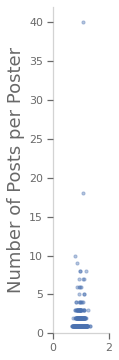

In [110]:
posters, post_counts = groupbyauthor()


fig, ax = plt.subplots(1,1, figsize=(1,6))
ax.scatter(x=stats.norm.rvs(1,size=len(post_counts),scale=.1),
           y=post_counts,
           s=10,
           alpha=.4)
ax.set_ylabel('Number of Posts per Poster')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0,xmax=2)
#plt.tight_layout()
plt.savefig('figures/pda_numposts.png')